Update nltk installation as meteor score is available on latest version of nltk

In [ ]:
!pip install -U nltk

     |████████████████████████████████| 1.5MB 18.3MB/s 
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
#import necessary libraries
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import string
import os
from PIL import Image
import glob
import pickle
from time import time
from tqdm import tqdm
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from collections import defaultdict
import re
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
#loading the data
wd =  'My Drive/CV_Project/flickr8k/'
data_dir = os.path.join(wd, 'data')
img_dir = os.path.join(data_dir, 'Images')

with open(os.path.join(data_dir, 'captions.txt'),'r') as f:
  captions = f.read()

images = list(os.listdir(img_dir))

In [ ]:
texts = captions.split('\n')
print (len(texts))
texts[:5]

40457


['image,caption',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .']

In [ ]:
texts.pop()

''

In [ ]:
img2captions = defaultdict(list)

i = 1
for text in tqdm(texts[1:]):
  #remove extra quote
  # text = re.sub('[\"]', '', text)
  # text = str(text)
  try:
    img_id, caption = text.split('.jpg,')
    img2captions[img_id].append(caption)
  except:
    print (i)
    print (text)
    break
  
  i+=1

100%|██████████| 40455/40455 [00:00<00:00, 707964.02it/s]


In [ ]:
len(list(img2captions.keys())), len(images)

(8091, 8091)

In [ ]:
s = 0
for img_id in img2captions.keys():
  s+= len(img2captions[img_id])

s

40455

### Preprocessing captions

The following preprocessing steps are performed on the captions for better generative language model

1) Word tokenization using nltk's word tokenize module.

2) Lower case folding.

3) Removing punctuations

4) Only consider alphabets. All other special characters and digits are removed.

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
table = str.maketrans('', '', string.punctuation)
def preprocess(comment):
    #1) tokenize
    tokens = word_tokenize(comment)
    
    #2) convert tokens to lower case
    tokens = [token.lower() for token in tokens]
    
    #3) Remove punctuations from tokens
    tokens = [token.translate(table) for token in tokens]
    
    # #4) Remove tokens which has a length less than 1
    # tokens = [token for token in tokens if len(token) >1]
    
    #5) Only consider tokens which are pure words(only strings of alphabets)
    tokens = [token for token in tokens if token.isalpha()]
    
    preprocessed_comment = ' '.join(tokens)
    
    return preprocessed_comment

In [ ]:
img_id = list(img2captions.keys())[0]
comments = img2captions[img_id]
comments

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
comment = comments[0]
preprocess(comment)

'a child in a pink dress is climbing up a set of stairs in an entry way'

In [ ]:
preprocessed_img_comments = {}
comment_count = 0
for img_id in tqdm(img2captions.keys()):
    comments = img2captions[img_id]
    t = []
    for comment in comments:
        comment_count +=1
        try:
            t.append(preprocess(comment))
        except:
            print (img_id,comment, comment_count)
            
    preprocessed_img_comments[img_id] = t

100%|██████████| 8091/8091 [00:04<00:00, 1698.21it/s]


In [ ]:
s = 0
for img_id in preprocessed_img_comments.keys():
    s += len(preprocessed_img_comments[img_id])
print (s)

40455


### Split data into train and test set

In [ ]:
from sklearn.model_selection import train_test_split
train_ids, test_ids = train_test_split(np.arange(len(images)), test_size = 0.3, random_state = 42, shuffle = True)

print (len(train_ids), len(test_ids))

5663 2428


In [ ]:
train = {}
test = {}

img_ids = list(preprocessed_img_comments.keys())

for i in train_ids:
  img_id = img_ids[i]
  train[img_id] = preprocessed_img_comments[img_id]

for i in test_ids:
  img_id = img_ids[i]
  test[img_id] = preprocessed_img_comments[img_id]

In [ ]:
len(train.keys()), len(test.keys())

(5663, 2428)

### Preprocess image

The Inception model is used to find the CNN based encoding for an image. So, the preprocessing for the image is done to transform the image into the same format as required by Inception model.

In [ ]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


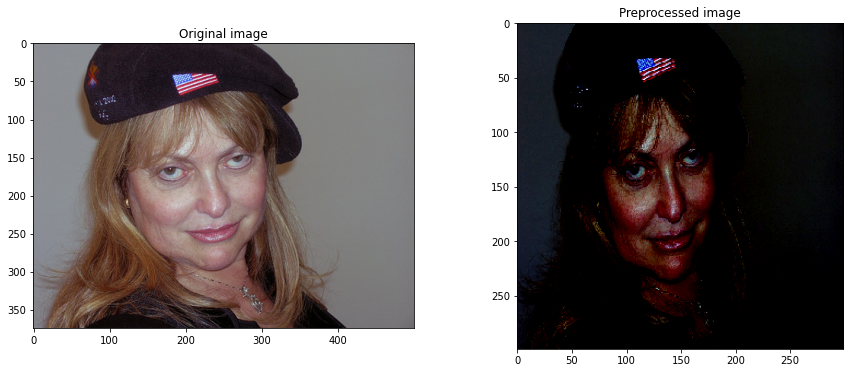

In [ ]:
from skimage.io import imread
r = np.random.randint(0, len(images))
sample_img = images[r]

img = imread(os.path.join(img_dir,sample_img))
img_preprocessed = preprocess(os.path.join(img_dir, sample_img))

fig, axs = plt.subplots(1,2,figsize = (15,6))
axs[0].imshow(img)
axs[0].set_title("Original image")

axs[1].imshow(img_preprocessed[0,:,:,:])
axs[1].set_title("Preprocessed image")

plt.show()

### CNN encoding of images (Inception v3 encoding)

In [ ]:
inception = InceptionV3(weights='imagenet')
model = Model(inception.input, inception.layers[-2].output)

def findAttributeVector(img_path):
    image = preprocess(img_path) # preprocess the image
    vec = model.predict(image) # Get the encoding vector for the image
    vec = np.reshape(vec, vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return vec

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
img_encoding = {}

for img in tqdm(images):
  img_path = os.path.join(img_dir, img)
  img_id = img[:-4]
  feature_vec = findAttributeVector(img_path)
  img_encoding[img_id] = feature_vec

100%|██████████| 8091/8091 [38:20<00:00,  3.52it/s]


In [ ]:
# saving the encoding so that for later runs loading it takes time and we won't need to run the above cell again
with open(os.path.join(wd, 'img_encoding_basic.pkl'), 'wb') as f:
  pickle.dump(img_encoding, f)

In [ ]:
#loading saved encoding
with open(os.path.join(wd, 'img_encoding_basic.pkl'),'rb') as f:
  img_encoding = pickle.load(f)

In [ ]:
#adding startsequence and end sequence tokens before and after each caption of train set
for id in tqdm(train.keys()):
  comments = train[id]
  t = []
  for comment in comments:
    c = '<s> ' + comment + ' </s>'
    t.append(c)

  train[id] = t

100%|██████████| 5663/5663 [00:00<00:00, 207453.11it/s]


In [ ]:
train_images = list(train.keys())
train[train_images[100]]

['<s> a guy doing tricks on a motorcycle </s>',
 '<s> a motorcyclist does a nose wheelie </s>',
 '<s> a person in a specialized suit rides a motorcycle </s>',
 '<s> motorcyclist performing while two men watch </s>',
 '<s> the rider is driving their motorcycle </s>']

### Building vocabulary for language model

In [ ]:
vocab = {}
for id in train.keys():
    comments = train[id]
    for comment in comments:
        words = comment.split(' ')
        for word in words:
            vocab[word] = vocab.get(word, 0) + 1
                
print ("Number of unique words in train corpus = %d" %(len(vocab.keys())))

Number of unique words in train corpus = 7520


Since there are a lot of unique words in the vocabulary, we should only consider some of them as the dimension of vocabulary otherwise would be huge. So, I am keeping only those words which has occured atleast 10 times in the train captions corpus.

In [ ]:
words = [word for word in vocab.keys() if vocab[word]>10]
len(words)

1539

In [ ]:
vocab_words = set(words)
#vocab_words.add('<unk>') #token for out vocabulary word
vocab_words.add('<pad>') #token for padding word
print (len(vocab_words)) 

1540


In [ ]:
# building a index dictionary for vocabulary words
word2idx = {}
idx2word = {}

word2idx['<pad>'] = 0
idx2word[0] = '<pad>'

idx = 1
for word in vocab_words :
  if word!='<pad>':
    word2idx[word] = idx
    idx2word[idx] = word
    idx+=1


## Building data generator

In [ ]:
max_len = 0
comment_lengths = []

for img_id in tqdm(train.keys()):
    for comment in train[img_id]:
        l = len(comment.split(' '))
        if l>max_len:
            max_len = l
        comment_lengths.append(l)
        
max_len

100%|██████████| 5663/5663 [00:00<00:00, 169794.22it/s]


37

In [ ]:

vocab_size = len(word2idx)

# data generator, intended to be used in a call to model.fit_generator()
def data_generator(data, attribute_vec, word2idx, max_len, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in data.items():
            n+=1
            # retrieve the image feature vector
            photo = attribute_vec[key]
            for desc in desc_list:
                # encode the sequence
                seq = [word2idx[word] for word in desc.split(' ') if word in word2idx]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_len)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

### Using GLOVE Embedding

In [ ]:

embeddings_index = {} # empty dictionary
f = open(os.path.join('My Drive/CV_Project/', 'glove.6B.100d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()

In [ ]:
embedding_dim = 100
vocab_size = len(word2idx)
# Get 100-dim dense vector for each of the words in our vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

### Build model

In [ ]:
# image feature extractor model
inputs1 = Input(shape=(2048,))
# partial caption sequence model
inputs2 = Input(shape=(max_len,))

fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)


se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder (feed forward) model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 37, 100)      154000      input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
model.layers[2]

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

### Train model on train set

In [ ]:
subset_size = len(train)
sample_train = {}
for img in train_images[:subset_size]:
  sample_train[img] = train[img]

In [ ]:
epochs = 10
number_pics_per_batch = 128
steps = len(sample_train)//number_pics_per_batch

In [ ]:
generator = data_generator(sample_train, img_encoding, word2idx, max_len, number_pics_per_batch)
losses = []
for e in range(epochs):
    print('Epoch', (e+1))
    batches = 0
    avg_loss_batches = 0
    n_batches = 0
    for batch_id in range(steps):
      n_batches+=1
      print ("Batch", (batch_id+1))
      X,y = next(generator)
      print (y.shape)
      history = model.fit(X,y, batch_size = 128)
      loss  = history.history['loss'][0]
      avg_loss_batches += loss
      batches += number_pics_per_batch
      if batches >= len(sample_train):
        break

    avg_loss_batches/= n_batches
    losses.append(avg_loss_batches)

Epoch 1
Batch 1
(7186, 1540)
57/57 [==============================] - 11s 84ms/step - loss: 5.8612
Batch 2
(7178, 1540)
57/57 [==============================] - 5s 82ms/step - loss: 4.8299
Batch 3
(7324, 1540)
58/58 [==============================] - 5s 82ms/step - loss: 4.4837
Batch 4
(7422, 1540)
58/58 [==============================] - 5s 84ms/step - loss: 4.3359
Batch 5
(7131, 1540)
56/56 [==============================] - 5s 82ms/step - loss: 4.1724
Batch 6
(7333, 1540)
58/58 [==============================] - 5s 83ms/step - loss: 4.1299
Batch 7
(7349, 1540)
58/58 [==============================] - 5s 84ms/step - loss: 4.0187
Batch 8
(7268, 1540)
57/57 [==============================] - 5s 83ms/step - loss: 4.0179
Batch 9
(7176, 1540)
57/57 [==============================] - 5s 85ms/step - loss: 3.8113
Batch 10
(7363, 1540)
58/58 [==============================] - 5s 84ms/step - loss: 3.8475
Batch 11
(7099, 1540)
56/56 [==============================] - 5s 86ms/step - loss: 3.6725

In [ ]:
# save model
model_checkpoint = os.path.join(wd, 'basic_captioning_full2')
model.save(model_checkpoint)

INFO:tensorflow:Assets written to: My Drive/CV_Project/flickr8k/basic_captioning_full2/assets


INFO:tensorflow:Assets written to: My Drive/CV_Project/flickr8k/basic_captioning_full2/assets


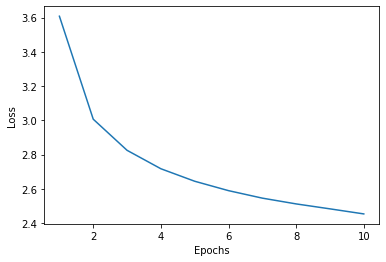

In [ ]:
ts = np.arange(1,epochs+1,1)
plt.plot(ts,losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
def greedySearch(photo, model = model):
    #photo = train_img_encoding[photo_id]
    photo  = photo[np.newaxis,...]
    in_text = '<s>'
    for i in range(max_len):
        sequence = [word2idx[w] for w in in_text.split() if w in word2idx]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx2word[yhat]
        in_text += ' ' + word
        if word == '</s>':
            break
    
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

### Check how good model trained on train set

In [ ]:
sample_images = list(sample_train.keys())
photo_id = sample_images[5]
print (photo_id)

3191982761_88793192ed


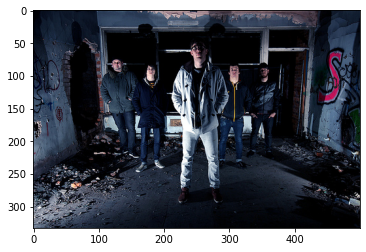

In [ ]:
from skimage.io import imread

img_path = os.path.join(img_dir, photo_id + '.jpg')
img = imread(img_path)
plt.imshow(img)
plt.show()

In [ ]:
photo = img_encoding[photo_id]
greedySearch(photo)

'a man and woman stand in front of a building'

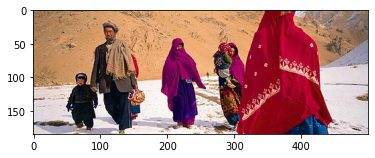

In [ ]:
photo_id = sample_images[49]
img_path = os.path.join(img_dir, photo_id + '.jpg')
img = imread(img_path)
plt.imshow(img)
plt.show()

In [ ]:
photo = img_encoding[photo_id]
greedySearch(photo)

'a group of people are standing in front of a large wave'

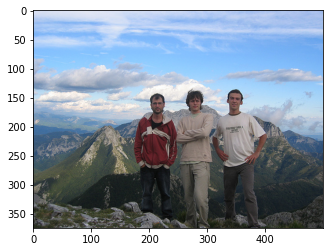

In [ ]:
r = np.random.randint(0, len(train))
photo_id = list(train.keys())[r]
img_path = os.path.join(img_dir, photo_id + '.jpg')
img = imread(img_path)
plt.imshow(img)
plt.show()

In [ ]:
photo = img_encoding[photo_id]
greedySearch(photo)

'a hiker stands on top of a mountain'

### Test set evaluation

In [ ]:
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def evaluate_test(subset_size = 200):
  avg_b1 = 0
  images = list(test.keys())
  avg_meteor = 0
  for test_img in tqdm(images[:subset_size]):
    photo = img_encoding[test_img]
    generated_caption = greedySearch(photo)

    test_captions = test[test_img]
    meteor = meteor_score(test_captions, generated_caption)
    avg_meteor += meteor
    references = [x.split(' ') for x in test_captions]
    candidate = generated_caption.split(' ')

    b1 = sentence_bleu(references, candidate, weights = (1,0))
    avg_b1 += b1

  avg_b1/=subset_size
  avg_meteor /= subset_size
  return avg_b1, avg_meteor  

In [ ]:
evaluate_test()

  1%|          | 2/200 [00:02<04:52,  1.48s/it]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
100%|██████████| 200/200 [01:31<00:00,  2.18it/s]


(0.5572737681704587, 0.36803338519231504)

In [ ]:
test_img_ids = list(test.keys())


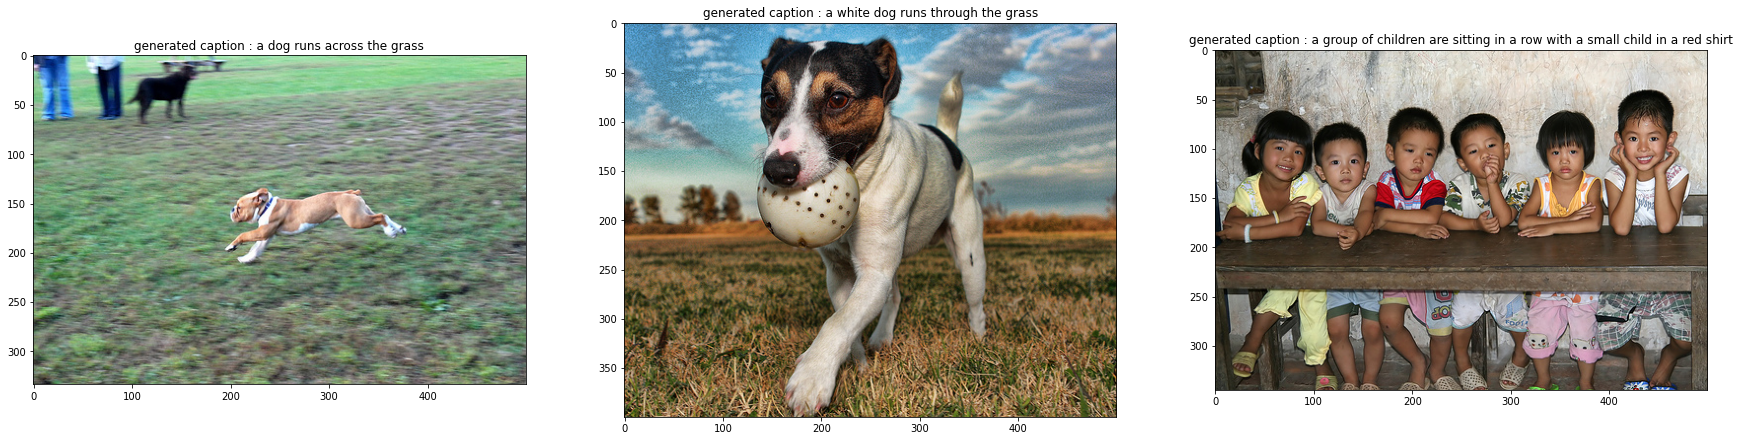

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (30,15))

seen = []
for i in range(3):
  while True:
    r = np.random.randint(0, len(test))
    if r not in seen:
      seen.append(r)
      break
  
  photo_id = test_img_ids[r]
  photo = img_encoding[photo_id]

  generated_caption = greedySearch(photo)

  img_path = os.path.join(img_dir, photo_id + '.jpg')
  img = imread(img_path)
  axs[i].imshow(img)
  axs[i].set_title("generated caption : %s" %generated_caption)

plt.show()

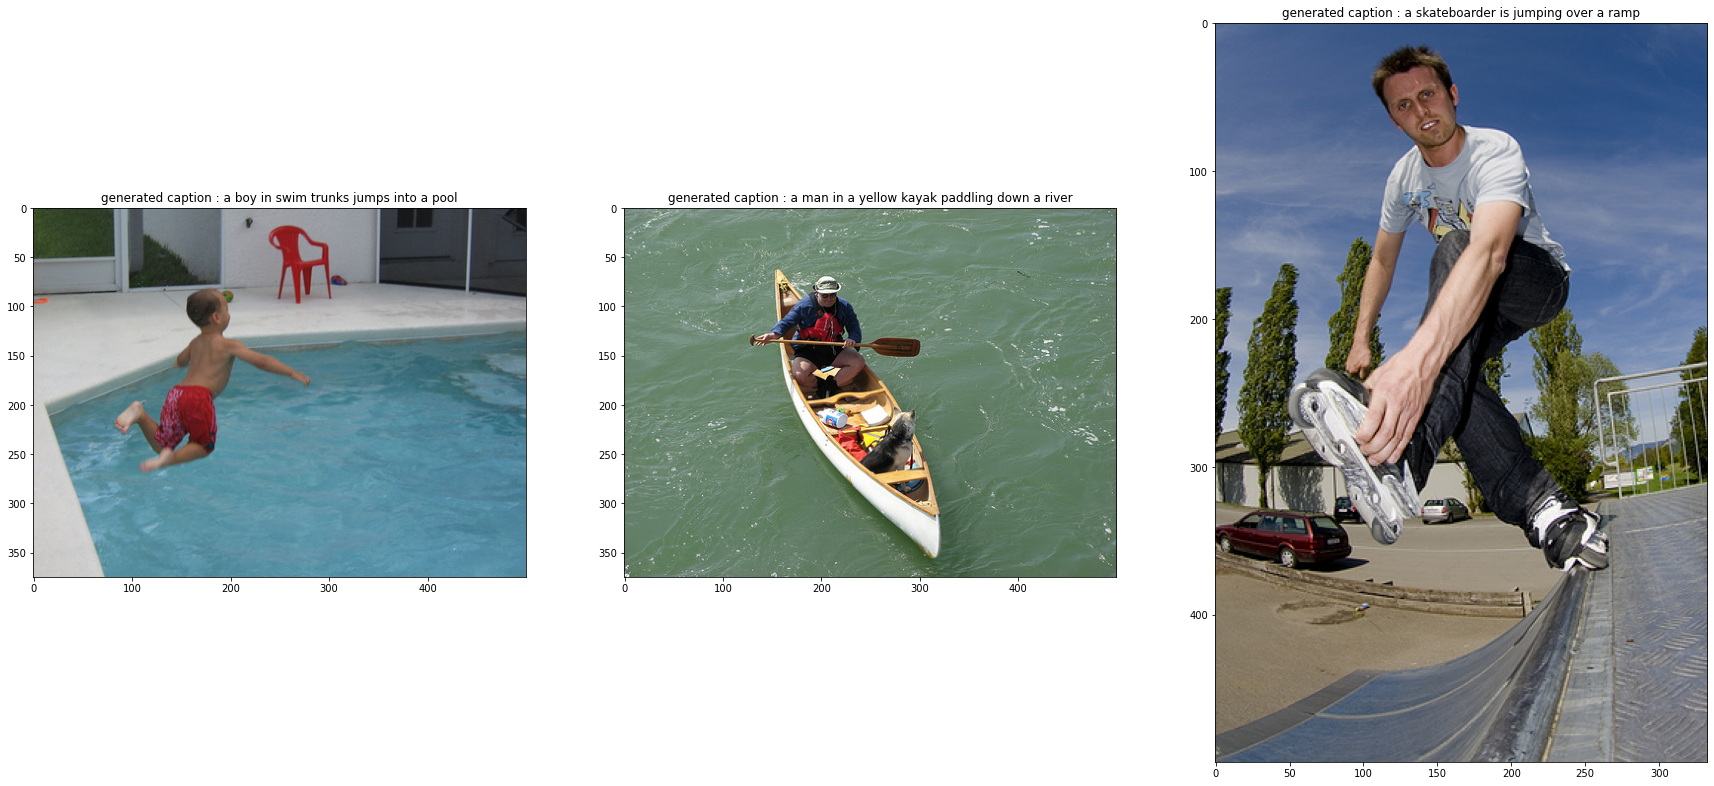

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (30,15))

seen = []
for i in range(3):
  while True:
    r = np.random.randint(0, len(test))
    if r not in seen:
      seen.append(r)
      break
  
  photo_id = test_img_ids[r]
  photo = img_encoding[photo_id]

  generated_caption = greedySearch(photo)

  img_path = os.path.join(img_dir, photo_id + '.jpg')
  img = imread(img_path)
  axs[i].imshow(img)
  axs[i].set_title("generated caption : %s" %generated_caption)

plt.show()

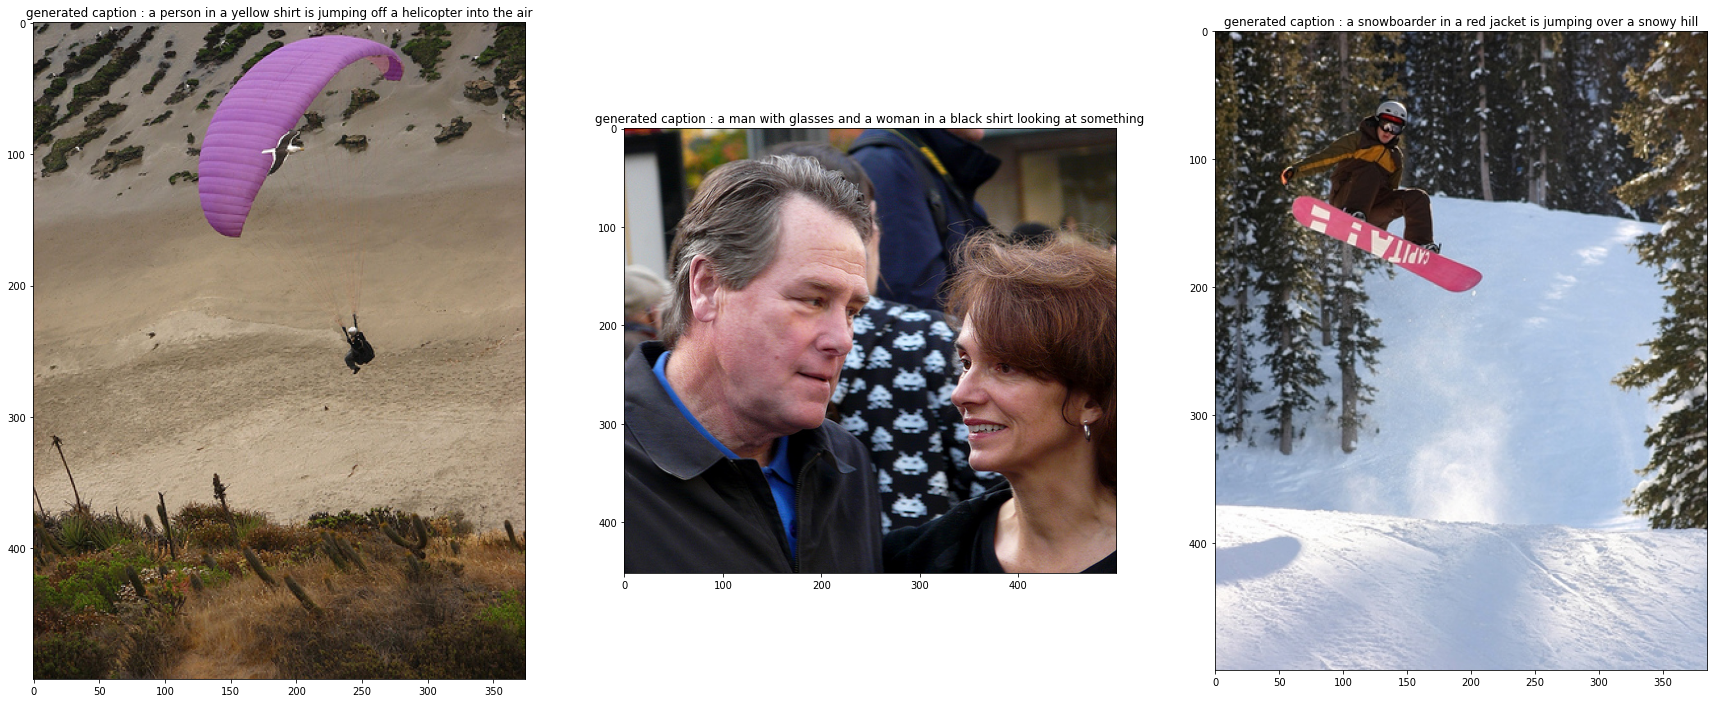

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (30,15))

seen = []
for i in range(3):
  while True:
    r = np.random.randint(0, len(test))
    if r not in seen:
      seen.append(r)
      break
  
  photo_id = test_img_ids[r]
  photo = img_encoding[photo_id]

  generated_caption = greedySearch(photo)

  img_path = os.path.join(img_dir, photo_id + '.jpg')
  img = imread(img_path)
  axs[i].imshow(img)
  axs[i].set_title("generated caption : %s" %generated_caption)

plt.show()

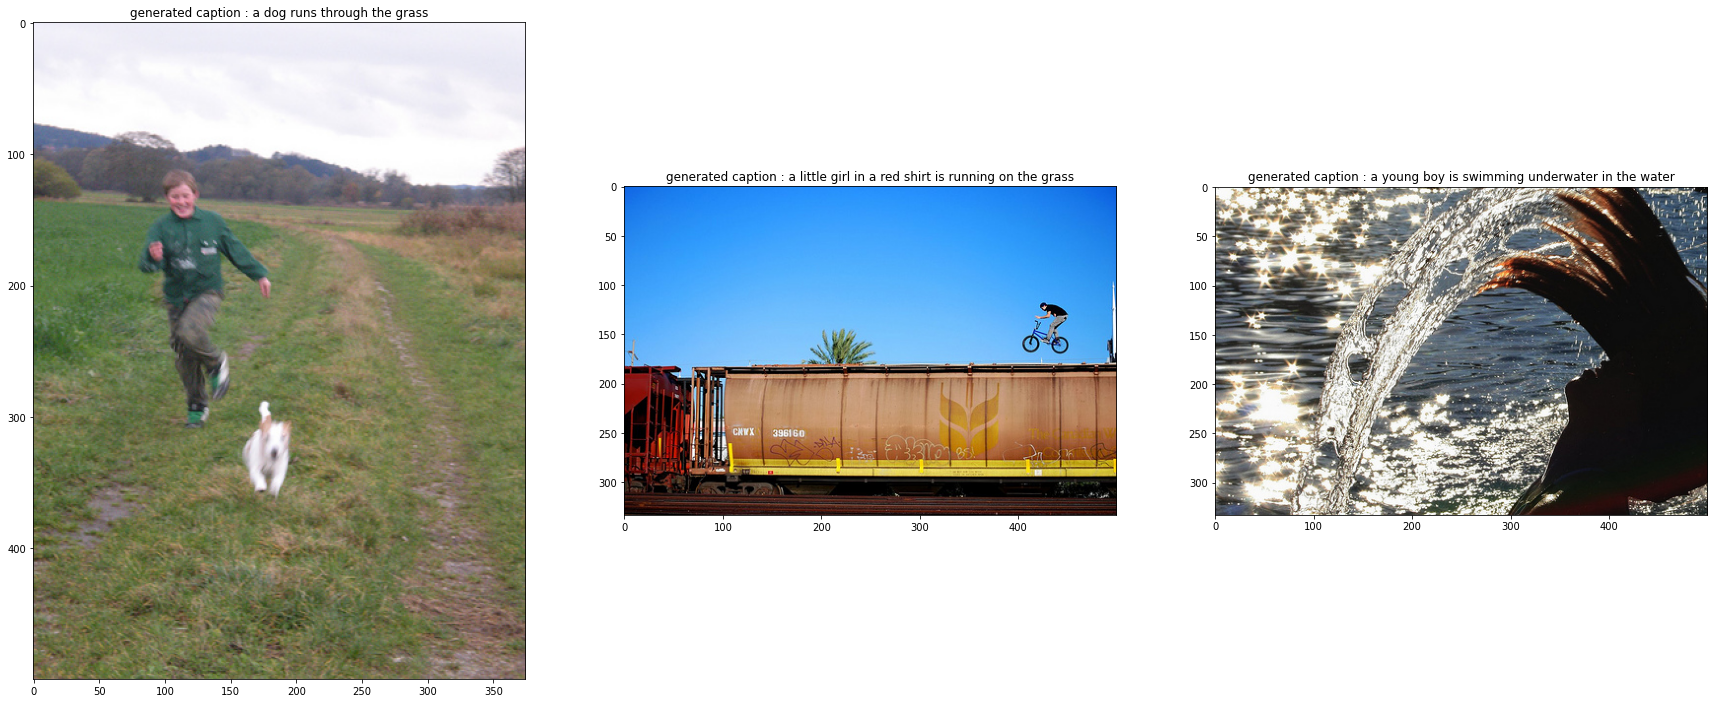

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (30,15))

seen = []
for i in range(3):
  while True:
    r = np.random.randint(0, len(test))
    if r not in seen:
      seen.append(r)
      break
  
  photo_id = test_img_ids[r]
  photo = img_encoding[photo_id]

  generated_caption = greedySearch(photo)

  img_path = os.path.join(img_dir, photo_id + '.jpg')
  img = imread(img_path)
  axs[i].imshow(img)
  axs[i].set_title("generated caption : %s" %generated_caption)

plt.show()

In [ ]:
evaluate_test(subset_size = len(test))

  0%|          | 2/2428 [00:00<17:02,  2.37it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
100%|██████████| 2428/2428 [19:02<00:00,  2.12it/s]


(0.5428187996999642, 0.3627139517955941)